In [1]:
# Optimization for Machine Learning
# Problem: projected gradient descent for SVM

%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pegasos import *
from cyclic_coordinate_descent import *
from random_coordinate_descent import *
from utils import *


from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
import os, struct
from array import array
from SMO import SMO
from RSMO import RSMO

np.random.seed(1337)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


### Load mnist training and validation images. Plot examples from both sets and show their corresponding labels as verification.

In [2]:
# mnist load images
train_imgs_dir = './dataset/mnist/train-images.idx3-ubyte'
train_labels_dir = './dataset/mnist/train-labels.idx1-ubyte'
val_imgs_dir = './dataset/mnist/t10k-images.idx3-ubyte'
val_labels_dir = './dataset/mnist/t10k-labels.idx1-ubyte'
train_imgs, train_labels = mnist_data_loader(train_imgs_dir, train_labels_dir)
print("mnist: number of training examples", train_imgs.shape[0])

val_imgs, val_labels = mnist_data_loader(val_imgs_dir, val_labels_dir)
print("mnist: number of validation examples", val_imgs.shape[0])
HEIGHT = 28
WIDTH = 28

# Reshape images to vectors
train_vectors = train_imgs.reshape(-1, HEIGHT * WIDTH)
val_vectors = val_imgs.reshape(-1, HEIGHT * WIDTH)

mnist: number of training examples 11769
mnist: number of validation examples 1932


## Plot Functions

In [3]:
# initialize w, lambda
num_examples, num_features = train_vectors.shape

def error_plot(w, _lambda, img_vectors, labels, algorithm, dilate=1, yscale='log'):
    """plot errors"""
    error_list = cal_objective_dilate(w, _lambda, img_vectors, labels, dilate)
    print(algorithm+" error:", error_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Error')
#     plt.yscale(yscale)
    num_iters = len(error_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), error_list, **kwargs)

def cal_objective_dilate(w, _lambda, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [objective(x, _lambda, img_vectors, labels) \
                                for x in w[0:num_iters:dilate]]

def acc_plot(w, img_vectors, labels, algorithm, dilate=1):
    """plot accuracies"""
    acc_list = cal_acc_dilate(w, img_vectors, labels, dilate)
    print(algorithm+" acc:", acc_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Acc')
    num_iters = len(acc_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), acc_list, **kwargs)

def cal_acc_dilate(w, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [compute_accuracy(x, img_vectors, labels) for x in w[0:num_iters:dilate]]

## Training error

In [4]:
def average_weight(w):
    w_sum = np.zeros([num_features,1])
    w_average = []
    for i in range(0,len(w)):
        w_sum += w[i]
        w_average.append(w_sum/(i+1))
    return w_average

def set_pegasos_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 3000
    return _lambda, num_steps, w0

def set_primal_cyclic_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

def set_primal_random_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias


In [5]:
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors, train_labels, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors, train_labels)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors, train_labels))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors, train_labels))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors, train_labels)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors, train_labels)

Pegasos training starts...
Iterations: 2999    total_time: 0.7873616218566895
Pegasos training ends...
Pegasos training error   0.09323970737729396
        
CCD training starts...
epoch: 0    total_time: 58.96103549003601
epoch: 1    total_time: 118.80778813362122
epoch: 2    total_time: 180.33092665672302
epoch: 3    total_time: 240.48495078086853
CCD training ends...
CCD training error:   0.6757469465971927
        
RCD training starts...
epoch: 0    total_time: 71.6229817867279
epoch: 1    total_time: 142.37413835525513
epoch: 2    total_time: 210.87320733070374
epoch: 3    total_time: 281.29147481918335
RCD training ends...
RCD training error:   0.6994320584251517
        
SMO training start
SMO training ends....
Iteration number exceeded the max of 1 iterations
using time : 110.01257491111755
SMO training start
SMO training ends....
Iteration number exceeded the max of 1 iterations
using time : 112.39061141014099


Pegasos error: 0.09343446579972894
CCD error: 0.6814037945720506
RCD error: 0.7026963249499174
SMO error: 0.10876819647327823
rSMO error: 0.12115139180286782


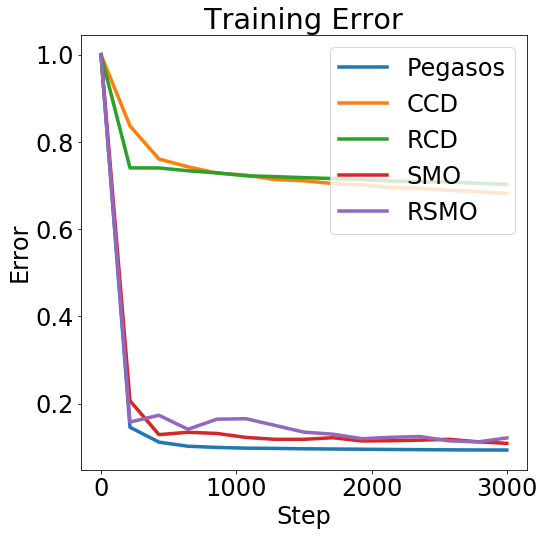

In [6]:
# training error plot
plot_dilation = 200
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors, train_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors, train_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors, train_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9841957685444813
CCD acc: 0.9547964992777637
RCD acc: 0.9722151414733622
SMO acc: 0.9835160166539213
rSMO acc: 0.9818166369275214


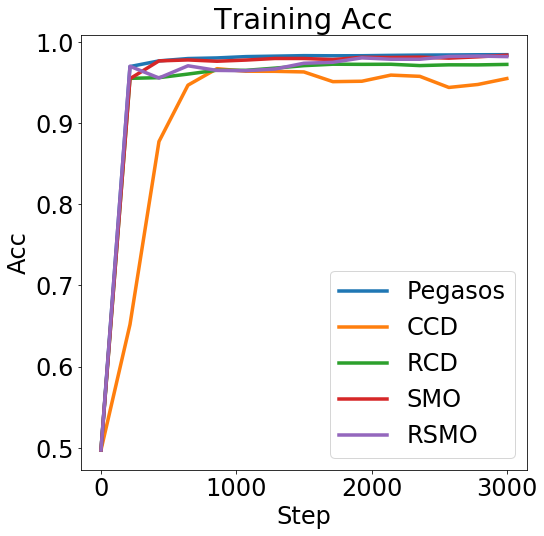

In [7]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors, train_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors, train_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors, train_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors, train_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.09737174782717348
CCD error: 0.6767131181393147
RCD error: 0.6976549010129247
SMO error: 0.11323604108417183
rSMO error: 0.12884163702645474


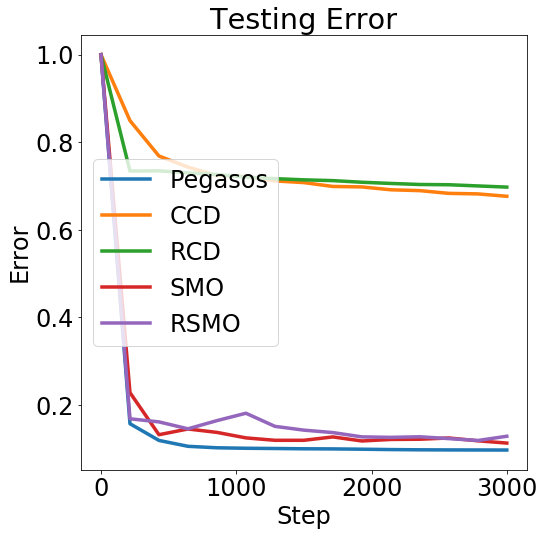

In [8]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9829192546583851
CCD acc: 0.9492753623188406
RCD acc: 0.9694616977225673
SMO acc: 0.9839544513457557
rSMO acc: 0.979296066252588


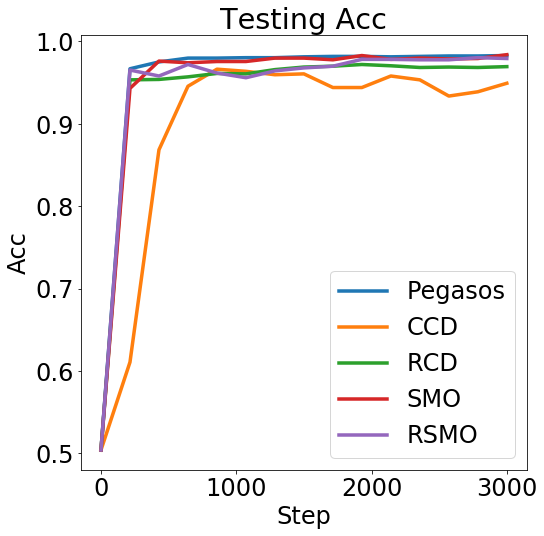

In [9]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

# Cifar Tests

In [ ]:
# Cifar
folder = 'dataset/cifar/'
train_vectors, train_labels, val_vectors, val_labels, label_names = get_cifar10(folder)
# print(train_vectors.shape, train_labels.shape, val_vectors.shape, val_labels.shape)
num_examples, num_features = train_vectors.shape

(10000, 3072)


In [ ]:
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors, train_labels, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors, train_labels)) # print final training error
print("        ")
# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors, train_labels))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors, train_labels, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors, train_labels))
print("        ")

# SVM using SMO descend
smo_model = SMO(max_iter=1, kernel_type='linear', C=1.0, epsilon=0.001)
smo_model.fit(train_vectors, train_labels)

# Random SMO
rsmo_model = RSMO(max_iter=1, kernel_type='linear', C=1.0, epsilon=0.001)
rsmo_model.fit(train_vectors, train_labels)

Pegasos training starts...
Iterations: 2999    total_time: 0.7164316177368164
Pegasos training ends...
Pegasos training error   0.46042017181324424
        
CCD training starts...
epoch: 0    total_time: 218.63177680969238


In [ ]:
# training error plot
plot_dilation = 200
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors, train_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors, train_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors, train_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors, train_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors, train_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors, train_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors, train_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors, train_labels, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [ ]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])